# Language modeling

Estimating the joint probability $p(\boldsymbol{\mathsf x}_1, \ldots,\boldsymbol{\mathsf x}_T)$ of sequences composed of discrete tokens prove useful for all sorts of reasons. This task is called *sequence* or *language modeling.*
For example, we want to evaluate the likelihood of sentences. We might wish to compare the naturalness to resolve ambiguity in candidate outputs generated by a machine translation or ASR system. In this case, we can reject outputs with low probability of occuring.

Language modeling gives us not only the capacity to evaluate likelihood, but the ability to generate sequences, and even to optimize for the most likely sequences. Recall that we can write a joint distribution as a chain of conditional distributions:

$$
p(\boldsymbol{\mathsf x}_1, \ldots,\boldsymbol{\mathsf x}_T) = p(\boldsymbol{\mathsf x}_1) \prod_{t = 2}^{T} p(\boldsymbol{\mathsf x}_{t} \mid \boldsymbol{\mathsf x}_{1}, \ldots, \boldsymbol{\mathsf x}_{t-1}).
$$

Hence, the output of a model for discrete data must be a distribution $p(\boldsymbol{\mathsf x}_{t} \mid \boldsymbol{\mathsf x}_{1}, \ldots, \boldsymbol{\mathsf x}_{t-1})$ for each token instead of expected values for regression models. In practice, this means that we need to have a finite collection of valid tokens called a **vocabulary**. Then, we can generate natural text, simply by drawing one token at a time $\boldsymbol{\mathsf{x}}_t \sim p(\boldsymbol{\mathsf{x}}_t \mid \boldsymbol{\mathsf{x}}_1, \ldots, \boldsymbol{\mathsf{x}}_{t-1})$. For example,

$$
\begin{aligned}
&p(\text{deep}, \text{learning}, \text{is}, \text{fun}) \\
= &p(\text{deep}) \cdot p(\text{learning} \mid \text{deep}) \cdot p(\text{is} \mid \text{deep}, \text{learning}) \cdot p(\text{fun} \mid \text{deep}, \text{learning}, \text{is}).
\end{aligned}
$$

where the probabilities can be estimated by [relative frequencies](https://en.wikipedia.org/wiki/Empirical_probability) perhaps with [Laplace smoothing](https://en.wikipedia.org/wiki/Additive_smoothing), e.g. $p(\text{deep} \mid \text{learning}) \approx \frac{\#(\text{deep},\, \text{learning})}{\#(\text{learning})}.$ Moreover, we usually truncate the context to at most $\tau$ many terms as a Markov hypothesis.

<br>

## Raw text to sequence data

For this chapter, we will extract character sequences from H. G. Wells' [*The Time Machine*](http://www.gutenberg.org/ebooks/35), a book containing just over 30,000 words. While real applications will typically involve significantly larger datasets, this is sufficient to demonstrate the preprocessing pipeline.

In [1]:
!mkdir ./data
!curl "https://www.gutenberg.org/cache/epub/35/pg35.txt" --output ./data/time_machine.txt

mkdir: ./data: File exists
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  199k  100  199k    0     0   117k      0  0:00:01  0:00:01 --:--:--  117k


This has some prefix by [Project Gutenberg](https://www.gutenberg.org/)[^1] that we have to remove:

[^1]: Project Gutenberg is an excellent source of literary text data. Moreover, the preprocessing steps for `.txt` files are the same for each text.

In [2]:
text = open("./data/time_machine.txt").read()
text[:300]

'\ufeffThe Project Gutenberg eBook of The Time Machine\n    \nThis ebook is for the use of anyone anywhere in the United States and\nmost other parts of the world at no cost and with almost no restrictions\nwhatsoever. You may copy it, give it away or re-use it under the terms\nof the Project Gutenberg License'

Data cleaning:

In [3]:
import re

start = "*** START OF THE PROJECT GUTENBERG EBOOK THE TIME MACHINE ***"
end = "*** END OF THE PROJECT GUTENBERG EBOOK THE TIME MACHINE ***"
text = text[text.find(start) + len(start): text.find(end)]
text = re.sub('[^A-Za-z]+', ' ', text).lower().strip()
print(len(text.split()))
print(text[:100])
print(text[-100:])

32895
the time machine an invention by h g wells contents i introduction ii the machine iii the time trave
when mind and strength had gone gratitude and a mutual tenderness still lived on in the heart of man


<br>

## Tokenization

Tokens are the *atomic* units of text. Each time step corresponds to 1 token, but what precisely constitutes a token is a design choice. For example, we could represent the sentence "Deep learning is fun" as a sequence of 4 tokens with 1 token for every word. Then, the set of all words comprise a large vocabulary (typically ~10-100K words). Or we would represent the same sentence as a much longer sequence of 30 characters, using a much smaller vocabulary (there are only 256 distinct ASCII characters). There is some tradeoff associated with the choice of vocabulary[^2].

[^2]: For example, using a larger vocabulary provides richer, context-aware understanding compared to ASCII-based tokenization. ASCII-only tokenization, such as treating each character as a token, loses essential semantic and syntactic information. Tokenization has [profound implications](https://x.com/karpathy/status/1759996551378940395) which we will cover in a future chapter.

The vocabulary acts like a dictionary that maps `token` $\mapsto$ `index` and also offers utilities such as an inversion map with `.to_tokens`.

In [4]:
%%save
import collections

class Vocab:
    def __init__(self, tokens=[], min_freq=0, reserved_tokens=[]):
        counter = collections.Counter(tokens)
        self.token_freqs = sorted(counter.items(), key=lambda x: x[1], reverse=True)
        self.itot = ["<unk>"] + list(sorted(set(
            reserved_tokens +   # i.e. not subject to min_freq
            [token for token, freq in self.token_freqs if freq >= min_freq]
        )))
        self.ttoi = {tok: idx for idx, tok in enumerate(self.itot)}

    def __len__(self):
        return len(self.itot)
    
    def __getitem__(self, tokens):
        if isinstance(tokens, (list, tuple)):
            return [self.__getitem__(tok) for tok in tokens]
        else:
            return self.ttoi.get(tokens, self.unk)
            
    def to_tokens(self, indices):
        if hasattr(indices, "__len__"):
            return [self.itot[int(index)] for index in indices]
        else:
            return self.itot[indices]

    @property
    def unk(self) -> int:
        return self.ttoi["<unk>"]

import collections

class Vocab:
    def __init__(self, tokens=[], min_freq=0, reserved_tokens=[]):
        counter = collections.Counter(tokens)
        self.token_freqs = sorted(counter.items(), key=lambda x: x[1], reverse=True)
        self.itot = ["<unk>"] + list(sorted(set(
            reserved_tokens +   # i.e. not subject to min_freq
            [token for token, freq in self.token_freqs if freq >= min_freq]
        )))
        self.ttoi = {tok: idx for idx, tok in enumerate(self.itot)}

    def __len__(self):
        return len(self.itot)
    
    def __getitem__(self, tokens):
        if isinstance(tokens, (list, tuple)):
            return [self.__getitem__(tok) for tok in tokens]
        else:
            return self.ttoi.get(tokens, self.unk)
            
    def to_tokens(self, indices):
        if hasattr(indices, "__len__"):
            return [self.itot[int(index)] for index in indices]
        else:
            return self.itot[indices]

    @property
    def unk(self) -> int:
        return self.ttoi["<unk>"]

Here we tokenize our preprocessed text into a sequence of characters:


In [5]:
tokens = list(text)
", ".join(tokens[:42])  # 42

't, h, e,  , t, i, m, e,  , m, a, c, h, i, n, e,  , a, n,  , i, n, v, e, n, t, i, o, n,  , b, y,  , h,  , g,  , w, e, l, l, s'

The *corpus* is just the tokens encoded to integers. Since the mapping is 1-1, we can just think of the corpus as the sequence of tokens.

In [6]:
vocab = Vocab(tokens)
corpus = vocab[tokens]

assert len(set(corpus)) + 1 == len(vocab)
print(len(vocab))
print(len(corpus))
print(vocab.token_freqs[:3], "...", vocab.token_freqs[-3:])
print(vocab.to_tokens(corpus[:16]))

28
174215
[(' ', 32894), ('e', 17918), ('t', 13591)] ... [('z', 106), ('j', 97), ('q', 95)]
['t', 'h', 'e', ' ', 't', 'i', 'm', 'e', ' ', 'm', 'a', 'c', 'h', 'i', 'n', 'e']


Defining the class for processing the dataset:

In [7]:
%%save
import re
import os
import requests


class TimeMachine:
    def __init__(self, download=False):
        self.filepath = "./data/time_machine.txt"
        if download or not os.path.exists(self.filepath):
            self._download()
        
    def _download(self):
        url = "https://www.gutenberg.org/cache/epub/35/pg35.txt"
        print(f"Downloading text from {url} ...", end=" ")
        response = requests.get(url, stream=True)
        response.raise_for_status()
        print("OK!")
        with open(self.filepath, "wb") as output:
            output.write(response.content)
        
    def _preprocess(self, text: str):
        s = "*** START OF THE PROJECT GUTENBERG EBOOK THE TIME MACHINE ***"
        e = "*** END OF THE PROJECT GUTENBERG EBOOK THE TIME MACHINE ***"
        text = text[text.find(s) + len(s): text.find(e)]
        text = re.sub('[^A-Za-z]+', ' ', text).lower().strip()
        return text
    
    def _tokenize(self, text: str):
        return list(text)

    def build(self, vocab=None):
        with open(self.filepath, "r") as f:
            text = f.read()
        
        text = self._preprocess(text)
        self.text = text
        self.tokens = self._tokenize(text)
        if vocab is None: 
            vocab = Vocab(self.tokens)

        corpus = vocab[self.tokens]
        return corpus, vocab

import re
import os
import requests


class TimeMachine:
    def __init__(self, download=False):
        self.filepath = "./data/time_machine.txt"
        if download or not os.path.exists(self.filepath):
            self._download()
        
    def _download(self):
        url = "https://www.gutenberg.org/cache/epub/35/pg35.txt"
        print(f"Downloading text from {url} ...", end=" ")
        response = requests.get(url, stream=True)
        response.raise_for_status()
        print("OK!")
        with open(self.filepath, "wb") as output:
            output.write(response.content)
        
    def _preprocess(self, text: str):
        s = "*** START OF THE PROJECT GUTENBERG EBOOK THE TIME MACHINE ***"
        e = "*** END OF THE PROJECT GUTENBERG EBOOK THE TIME MACHINE ***"
        text = text[text.find(s) + len(s): text.find(e)]
        text = re.sub('[^A-Za-z]+', ' ', text).lower().strip()
        return text
    
    def _tokenize(self, text: str):
        return list(text)

    def build(self, vocab=None):
        with open(self.filepath, "r") as f:
            text = f.read()
        
        text = self._preprocess(text)
        self.text = text
        self.tokens = self._tokenize(text)
        if vocab is None: 
            vocab = Vocab(self.tokens)

        corpus = vocab[self.tokens]
        return corpus, vocab

Basic usage starts with download and then build:

In [8]:
tm = TimeMachine(download=True)
corpus, vocab = tm.build()

In [9]:
print(type(tm.text))
print(tm.text[:100])
print(tm.text[-100:])
print(len(corpus), len(vocab))

<class 'str'>
the time machine an invention by h g wells contents i introduction ii the machine iii the time trave
when mind and strength had gone gratitude and a mutual tenderness still lived on in the heart of man
174215 28


Trying out the `<unk>` token for unknown characters:

In [10]:
vocab.to_tokens(vocab[list("$w@gger")])

['<unk>', 'w', '<unk>', 'g', 'g', 'e', 'r']

## Appendix: Zipf's law

After a few words that are considered exceptions, the frequency $f_i$ of the $i$-th most frequent word decays as follows:

$$f_i \propto i^{-\alpha}.$$

Equivalently,

$$\log f_i = -\alpha \log i + c$$

where $\alpha$ characterizes the token distribution and $c$ is a constant for the proportionality.

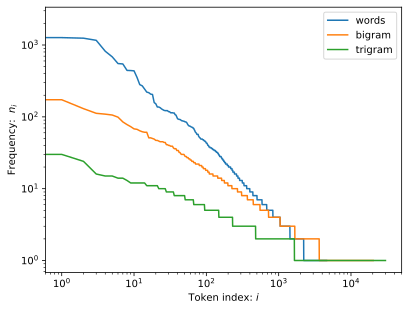

In [11]:
%matplotlib inline
%config InlineBackend.figure_format = "svg"
import matplotlib.pyplot as plt

words = text.split()
word_freqs = Vocab(words).token_freqs
bigram_freqs = Vocab(["__".join(pair) for pair in zip(words[:-1], words[1:])]).token_freqs
trigram_freqs = Vocab(["__".join(triple) for triple in zip(words[:-2], words[1:-1], words[2:])]).token_freqs

plt.plot([freq for _, freq in word_freqs], label="words")
plt.plot([freq for _, freq in bigram_freqs], label="bigram")
plt.plot([freq for _, freq in trigram_freqs], label="trigram")
plt.yscale("log")
plt.xscale("log")
plt.ylabel("Frequency:  $n_i$")
plt.xlabel("Token index: $i$")
plt.legend();

**Remark.** Similar behavior (even a similar $\alpha$) has been observed for [*Alice's Adventures in Wonderland*](https://www.gutenberg.org/cache/epub/11/pg11.txt) which is likewise an English stories of similar length.